# Importation des carreaux INSEE et premières cartes


Le fichier avec les carreaux de 1km de l'Insee est très volumineux : afin de pouvoir le télécharger un traitement a été fait sur QGIS pour extraire un "sous-fichier" qui ne contient que les lignes des carreaux situés en Île de France.

Ces données sont stockées sur un *Google Drive* sous forme d'un dossier ZIP qui contient tous les élements permettant de lire le fichier *.shp*.

Le code *donnees_INSEE.py* permet de créer une fonction qui reprend exactement ce *NoteBook* et permettra de télécharger les données de facon automatisées dans les autres parties de notre projet.

## Importation des données

In [36]:
import geopandas as gpd
import pandas as pd
import requests
from io import BytesIO  
from zipfile import ZipFile
import tempfile
import os
import matplotlib.pyplot as plt
from shapely.geometry import Point

Les commandes suivantes permettent de faire des cartes avec cartiflette.

In [ ]:
!pip install pandas fiona shapely pyproj rtree
!pip install geopandas
!pip install topojson

In [ ]:
!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

In [9]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

In [10]:
url_zip="https://drive.google.com/uc?export=download&id=1U9HT438foGzW06JdtVC3_ByA17Qipyrd"

response = requests.get(url_zip)

# Créer un répertoire temporaire pour stocker les fichiers
with tempfile.TemporaryDirectory() as tmpdirname:
    with ZipFile(BytesIO(response.content)) as zipfile:
        # Extraire tous les fichiers dans le répertoire temporaire
        zipfile.extractall(tmpdirname)

        # Rechercher le fichier .shp dans le répertoire temporaire
        for file_name in os.listdir(tmpdirname):
            if file_name.endswith('.shp'):
                shp_path = os.path.join(tmpdirname, file_name)
                data = gpd.read_file(shp_path)  

In [46]:
url="https://data.iledefrance-mobilites.fr/api/explore/v2.1/catalog/datasets/emplacement-des-gares-idf/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
stations=pd.read_csv(url, sep=";")
stations = gpd.GeoDataFrame(stations, geometry=[Point(xy) for xy in zip(stations.x, stations.y)])
stations.crs = "EPSG:2154"

In [47]:
stations.crs

<Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

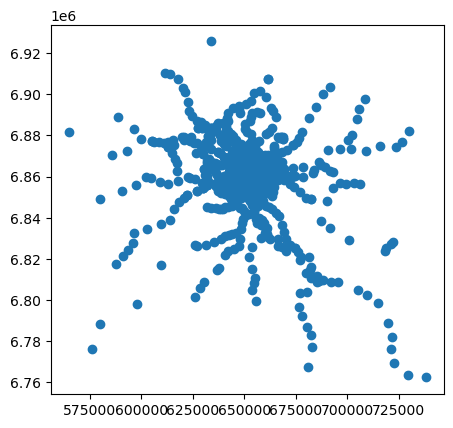

In [38]:
stations.plot()

## Statistiques de base

In [11]:
data.head()

,idcar_1km,i_est_1km,lcog_geo,ind,men,men_pauv,men_1ind,men_5ind,men_prop,men_fmp,...,ind_25_39,ind_40_54,ind_55_64,ind_65_79,ind_80p,ind_inc,pre_IDF,select,expt,geometry
0,CRS3035RES1000mN2774000E3848000,0,8932889437,136.5,49.9,2.0,10.1,5.0,44.0,6.1,...,21.1,40.0,11.0,11.0,2.0,0.0,NaN,1,1,"POLYGON ((749984.489 6755406.883, 749892.891 6..."
1,CRS3035RES1000mN2775000E3842000,0,89382,708.0,325.1,25.0,105.0,15.0,240.9,38.0,...,105.9,145.1,98.0,140.1,36.9,0.0,NaN,1,1,"POLYGON ((743922.298 6755837.684, 743830.655 6..."
2,CRS3035RES1000mN2775000E3843000,0,8938289201,513.0,231.0,15.9,85.0,9.9,172.1,24.0,...,68.9,126.0,68.1,77.0,22.0,0.0,NaN,1,1,"POLYGON ((744917.401 6755931.740, 744825.763 6..."
3,CRS3035RES1000mN2775000E3844000,1,8920189382,5.0,1.9,0.0,0.3,0.0,1.6,0.1,...,1.0,1.0,0.5,0.9,0.2,0.0,NaN,1,1,"POLYGON ((745912.502 6756025.784, 745820.870 6..."
4,CRS3035RES1000mN2775000E3845000,1,89201,4.0,1.5,0.0,0.3,0.0,1.3,0.1,...,0.8,0.8,0.4,0.7,0.1,0.0,NaN,1,1,"POLYGON ((746907.601 6756119.816, 746815.976 6..."


In [14]:
data.shape

(16817, 35)

In [16]:
data.crs

<Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [51]:
import cartiflette.s3 as s3

shp_communes = s3.download_vectorfile_url_all(
    crs = 4326,
    values = ["75", "92", "93", "94", "77", "78", "91", "95"],
    borders="COMMUNE",
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=75/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 14.5kiB [00:00, 16.9MiB/s]

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=92/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson



Downloading: : 62.3kiB [00:00, 12.8MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=93/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 119kiB [00:00, 40.0MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=94/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 110kiB [00:00, 35.8MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=77/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.56MiB [00:00, 29.3MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=78/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 576kiB [00:00, 29.2MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=91/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 479kiB [00:00, 40.1MiB/s]


https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=95/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 368kiB [00:00, 31.6MiB/s]


In [52]:
arrondissements = s3.download_vectorfile_url_all(
    crs = 4326,
    values = ["75"],
    borders="COMMUNE_ARRONDISSEMENT",
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=75/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 40.1kiB [00:00, 36.3MiB/s]


In [53]:
shp_communes = pd.concat(
  [
    shp_communes.loc[shp_communes['INSEE_DEP'] != "75"].to_crs(2154),
    arrondissements.to_crs(2154)
  ])

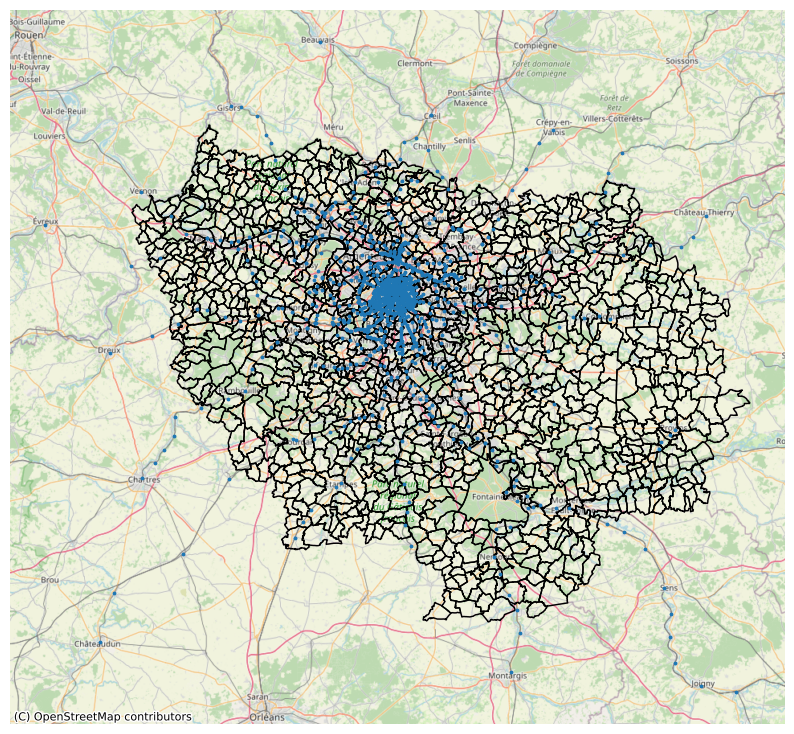

In [54]:
fig,ax = plt.subplots(figsize=(10, 10))
#data.to_crs(3857).plot(ax = ax, color = 'red', alpha = 0.4, zorder=2)
shp_communes.to_crs(3857).plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
stations.to_crs(3857).plot(ax = ax, markersize=3)
ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

## Premières jointures

In [56]:
stations.head(1)

,Geo Point,Geo Shape,gares_id,nom_long,nom_so_gar,nom_su_gar,id_ref_ZdC,nom_ZdC,id_ref_ZdA,nom_ZdA,...,tertram,terval,exploitant,idf,principal,x,y,picto ligne,nom_iv,geometry
0,"48.83908975449538, 2.2704582437872416","{""coordinates"": [2.270458243787242, 48.8390897...",57,Pont du Garigliano,Hôpital Européen Georges Pompidou,NaN,74002,Pont du Garigliano - Hôpital Européen G. Pompidou,58798,Pont du Garigliano - Hôpital Européen G. Pompidou,...,0,0,SNCF,1,0,646453.5639,6.860141e+06,https://data.iledefrance-mobilites.fr/api/expl...,Pont du Garigliano,POINT (646453.564 6860140.614)


In [57]:
data.head(1)

,idcar_1km,i_est_1km,lcog_geo,ind,men,men_pauv,men_1ind,men_5ind,men_prop,men_fmp,...,ind_25_39,ind_40_54,ind_55_64,ind_65_79,ind_80p,ind_inc,pre_IDF,select,expt,geometry
0,CRS3035RES1000mN2774000E3848000,0,8932889437,136.5,49.9,2.0,10.1,5.0,44.0,6.1,...,21.1,40.0,11.0,11.0,2.0,0.0,NaN,1,1,"POLYGON ((749984.489 6755406.883, 749892.891 6..."


In [69]:
stations_socio = gpd.sjoin(stations, data, how='inner', predicate='intersects')

In [70]:
stations_socio.head()

,Geo Point,Geo Shape,gares_id,nom_long,nom_so_gar,nom_su_gar,id_ref_ZdC,nom_ZdC,id_ref_ZdA,nom_ZdA,...,ind_18_24,ind_25_39,ind_40_54,ind_55_64,ind_65_79,ind_80p,ind_inc,pre_IDF,select,expt
0,"48.83908975449538, 2.2704582437872416","{""coordinates"": [2.270458243787242, 48.8390897...",57,Pont du Garigliano,Hôpital Européen Georges Pompidou,NaN,74002,Pont du Garigliano - Hôpital Européen G. Pompidou,58798,Pont du Garigliano - Hôpital Européen G. Pompidou,...,1279.0,3241.0,3167.5,1862.5,2160.0,1156.0,9.0,1.0,1,1
129,"48.84524756452023, 2.261623492404885","{""coordinates"": [2.261623492404885, 48.8452475...",544,Michel Ange-Molitor,NaN,NaN,73658,Michel-Ange - Molitor,44139,Michel-Ange - Molitor,...,1279.0,3241.0,3167.5,1862.5,2160.0,1156.0,9.0,1.0,1,1
348,"48.83807588962523, 2.271174403433847","{""coordinates"": [2.271174403433847, 48.8380758...",978,Pont du Garigliano,Hôpital Européen Georges Pompidou,NaN,74002,Pont du Garigliano - Hôpital Européen G. Pompidou,58798,Pont du Garigliano - Hôpital Européen G. Pompidou,...,1279.0,3241.0,3167.5,1862.5,2160.0,1156.0,9.0,1.0,1,1
370,"48.84505817137918, 2.261745124963671","{""coordinates"": [2.261745124963671, 48.8450581...",545,Michel Ange-Molitor,NaN,NaN,73658,Michel-Ange - Molitor,44139,Michel-Ange - Molitor,...,1279.0,3241.0,3167.5,1862.5,2160.0,1156.0,9.0,1.0,1,1
1128,"48.84520470264663, 2.2664415417194004","{""coordinates"": [2.2664415417194, 48.845204702...",149,Chardon Lagache,NaN,NaN,71141,Chardon Lagache,42543,Chardon Lagache,...,1279.0,3241.0,3167.5,1862.5,2160.0,1156.0,9.0,1.0,1,1


In [71]:
stations_socio.columns

Index(['Geo Point', 'Geo Shape', 'gares_id', 'nom_long', 'nom_so_gar',
       'nom_su_gar', 'id_ref_ZdC', 'nom_ZdC', 'id_ref_ZdA', 'nom_ZdA',
       'idrefliga', 'idrefligc', 'res_com', 'indice_lig', 'mode_', 'tertrain',
       'terrer', 'termetro', 'tertram', 'terval', 'exploitant', 'idf',
       'principal', 'x', 'y', 'picto ligne', 'nom_iv', 'geometry',
       'index_right', 'idcar_1km', 'i_est_1km', 'lcog_geo', 'ind', 'men',
       'men_pauv', 'men_1ind', 'men_5ind', 'men_prop', 'men_fmp', 'ind_snv',
       'men_surf', 'men_coll', 'men_mais', 'log_av45', 'log_45_70',
       'log_70_90', 'log_ap90', 'log_inc', 'log_soc', 'ind_0_3', 'ind_4_5',
       'ind_6_10', 'ind_11_17', 'ind_18_24', 'ind_25_39', 'ind_40_54',
       'ind_55_64', 'ind_65_79', 'ind_80p', 'ind_inc', 'pre_IDF', 'select',
       'expt'],
      dtype='object')

In [82]:
stations_socio.loc[:,["ind", "men", "men_pauv", "men_1ind", "men_5ind", 'men_prop', 'men_fmp', 'ind_snv',
       'men_surf', 'men_coll', 'men_mais', 'log_av45', 'log_45_70',
       'log_70_90', 'log_ap90', 'log_inc', 'log_soc', 'ind_0_3', 'ind_4_5',
       'ind_6_10', 'ind_11_17', 'ind_18_24', 'ind_25_39', 'ind_40_54',
       'ind_55_64', 'ind_65_79', 'ind_80p']].describe()

,ind,men,men_pauv,men_1ind,men_5ind,men_prop,men_fmp,ind_snv,men_surf,men_coll,...,ind_0_3,ind_4_5,ind_6_10,ind_11_17,ind_18_24,ind_25_39,ind_40_54,ind_55_64,ind_65_79,ind_80p
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1.176000e+03,1.176000e+03,1176.000000,...,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000
mean,12547.391582,6011.120323,888.144558,2788.553401,392.212925,2210.139371,606.565306,3.986702e+08,3.589784e+05,5639.349830,...,575.756207,279.581803,688.330442,937.476531,871.663095,3164.701361,2542.090306,1412.822874,1464.144218,573.211139
std,11152.089037,5884.195818,875.421454,3137.695312,327.458872,2162.326749,526.486741,4.003123e+08,3.176741e+05,5938.176341,...,473.728174,220.244431,538.625595,747.273522,724.398740,3206.161066,2265.012929,1268.418161,1406.224184,572.508563
min,1.000000,0.400000,0.000000,0.100000,0.000000,0.000000,0.000000,2.532300e+04,3.630000e+01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.100000,0.000000,0.100000,0.000000
25%,3614.250000,1543.825000,161.000000,485.750000,122.925000,624.750000,196.800000,8.862993e+07,1.094334e+05,985.700000,...,196.000000,100.250000,243.325000,324.975000,274.475000,764.025000,733.900000,403.750000,362.750000,132.075000
50%,8403.000000,3666.000000,604.000000,1421.000000,309.000000,1429.000000,436.000000,2.355084e+08,2.406600e+05,3436.000000,...,445.900000,224.000000,556.000000,715.250000,655.500000,2007.250000,1784.000000,940.000000,872.000000,334.000000
75%,19804.000000,9352.000000,1394.000000,4165.000000,619.000000,3260.000000,935.000000,6.323013e+08,5.479950e+05,8864.000000,...,901.500000,463.250000,1094.000000,1419.600000,1408.125000,4676.375000,3788.750000,2168.000000,2406.000000,877.000000
max,46551.000000,26638.000000,3762.000000,15154.000000,1663.000000,10593.000000,2127.000000,1.500639e+09,1.247443e+06,26455.000000,...,2066.500000,858.500000,2097.500000,2899.000000,2634.000000,16111.000000,9310.000000,4792.000000,5242.000000,2423.000000
